In [1]:
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

from utils.utils import create_data_pipeline
from models.mohamed_ashraf.bilstm4 import BiLSTM

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
with open('utils/diacritic2id.pickle', 'rb') as f:
    diacritic2idx = pickle.load(f)

with open('utils/letter2idx.pickle', 'rb') as f:
    letter2idx = pickle.load(f)

In [4]:
vocab_size = len(letter2idx)
num_classes = len(diacritic2idx)

print(f"Vocab size: {vocab_size}, Number of classes: {num_classes}")

Vocab size: 38, Number of classes: 16


In [5]:
def pad_collate_fn(batch):
    x_batch, y_batch, mask_batch = zip(*batch)
    lengths_x = [len(x) for x in x_batch]
    x_padded = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=letter2idx['<PAD>'])
    y_padded = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=diacritic2idx['<PAD>'])
    mask_spadded = torch.nn.utils.rnn.pad_sequence(mask_batch, batch_first=True, padding_value=0)
    return x_padded, y_padded, mask_spadded, torch.tensor(lengths_x, dtype=torch.long)

In [6]:
test_dataset,  test_loader= create_data_pipeline(
    corpus_path='./data/val.txt', 
    letter2idx=letter2idx, 
    diacritic2idx=diacritic2idx, 
    collate_fn=pad_collate_fn,
    train=False, 
    batch_size=32
)

In [7]:
model = BiLSTM(vocab_size=vocab_size, num_classes=num_classes)

In [9]:
checkpoint = torch.load("./models/mohamed_ashraf/bilstm4.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
# print(f"Validation Loss: {checkpoint['val_loss']:.4f}")
# print(f"Validation Accuracy: {checkpoint['val_accuracy']:.4f}")

/tmp/ipykernel_115306/1870947648.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./models/mohamed_ashraf/bilstm4.pth", map_location=device)


BiLSTM(
  (embedding): Embedding(38, 256, padding_idx=13)
  (bilstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (emb_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lstm_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attention): SelfAttention(
    (query): Linear(in_features=512, out_features=512, bias=True)
    (key): Linear(in_features=512, out_features=512, bias=True)
    (value): Linear(in_features=512, out_features=512, bias=True)
    (out): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (attn_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc1_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=16, bias=True)
)

In [10]:
@torch.no_grad()
def evaluate_full_sequence(model, data_loader, return_preds=False):
    model.eval()
    total_correct = 0
    total_tokens = 0
    all_preds = []
    all_targets = []

    for batch_X, batch_y, _, _ in data_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_X)
        preds = outputs.argmax(dim=-1)

        mask = (batch_y != 15)
        correct = (preds[mask] == batch_y[mask]).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
        
        if return_preds:
            all_preds.extend(preds[mask].cpu().numpy().tolist())
            all_targets.extend(batch_y[mask].cpu().numpy().tolist())

    acc = total_correct / total_tokens if total_tokens > 0 else 0
    
    if return_preds:
        return acc, np.array(all_preds), np.array(all_targets)
    return acc


@torch.no_grad()
def evaluate_last_char_accuracy(model, data_loader, return_preds=False):
    model.eval()
    total_correct = 0
    total_important = 0
    all_preds = []
    all_targets = []

    for batch_X, batch_y, batch_mask, _ in data_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        batch_mask = batch_mask.to(device)

        outputs = model(batch_X)
        preds = outputs.argmax(dim=-1)

        mask = (batch_mask == 1)
        correct = (preds[mask] == batch_y[mask]).sum().item()
        total_correct += correct
        total_important += mask.sum().item()
        
        if return_preds:
            all_preds.extend(preds[mask].cpu().numpy().tolist())
            all_targets.extend(batch_y[mask].cpu().numpy().tolist())

    acc = total_correct / total_important if total_important > 0 else 0
    
    if return_preds:
        return acc, np.array(all_preds), np.array(all_targets)
    return acc

In [11]:
full_acc, full_preds, full_targets = evaluate_full_sequence(model, test_loader, return_preds=True)
last_char_acc, last_char_preds, last_char_targets = evaluate_last_char_accuracy(model, test_loader, return_preds=True)

print(f"Full sequence accuracy: {full_acc:.4f}")
print(f"Last char accuracy: {last_char_acc:.4f}")

Full sequence accuracy: 0.9581
Last char accuracy: 0.9152


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

In [ ]:
idx2diacritic = {v: k for k, v in diacritic2idx.items()}
label_names = [idx2diacritic[i] for i in range(len(idx2diacritic))]

print(f"Diacritic labels: {label_names}")

Diacritic labels: ['َ', 'ً', 'ُ', 'ٌ', 'ِ', 'ٍ', 'ْ', 'ّ', 'َّ', 'ًّ', 'ُّ', 'ٌّ', 'ِّ', 'ٍّ', '', '<PAD>']


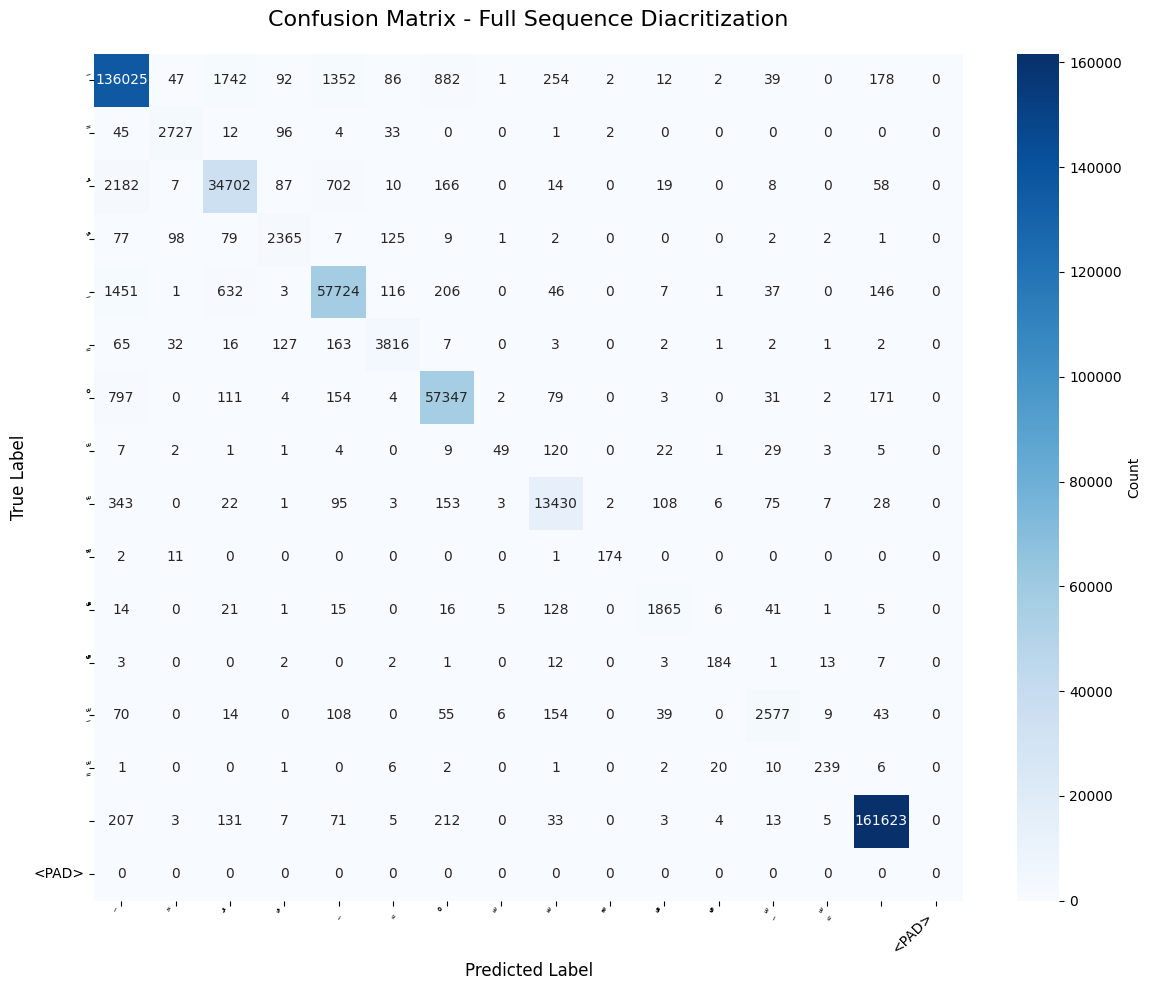

In [ ]:
cm_full = plot_confusion_matrix(
    full_targets, 
    full_preds, 
    label_names,
    'Confusion Matrix - Full Sequence Diacritization'
)

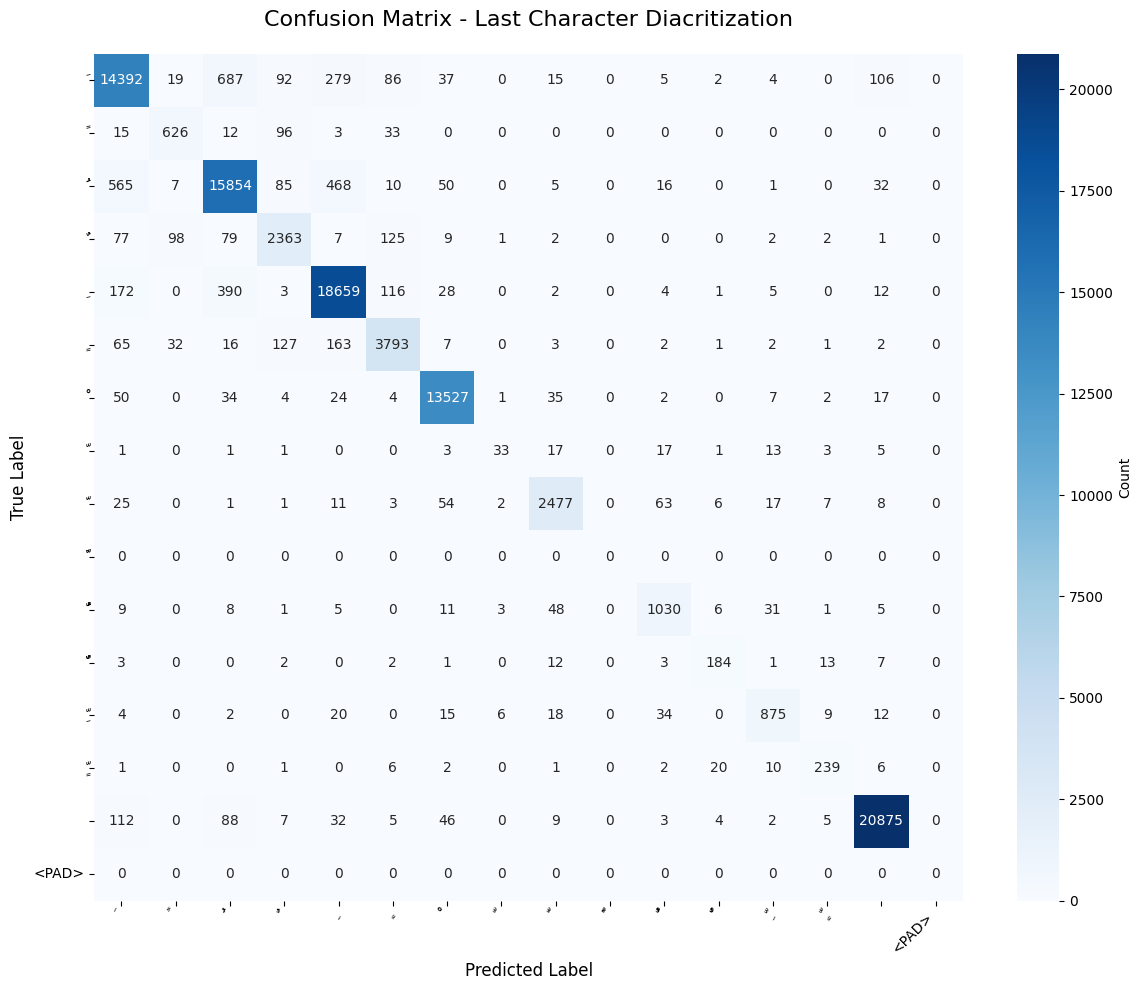

In [ ]:
cm_last = plot_confusion_matrix(
    last_char_targets, 
    last_char_preds, 
    label_names,
    'Confusion Matrix - Last Character Diacritization'
)